## Test a class for the easy retrieval of postgres data via Jupyter widgets


In [1]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

In [2]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data


In [3]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


### Make an empty dataframe and call the retrieval function

In [218]:
base_dataframe = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 

In [219]:
psql = psql_neuroballs(base_dataframe)

62 animals across 6 experimenters found!
Total # of 5950 sessions (unique clusters: 11196)


In [220]:
psql.retrieve_data()

Retrieving data ... (Empty dataframe) ...
8785 entries retrieved.


In [203]:
base_dataframe = psql.data()

In [204]:
base_dataframe.columns

Index([u'tetrode_no', u'animal_id', u'n_drive_user', u'session_ts',
       u'cluster_no', u'session_name', u'hdpeakrate', u'sparsity',
       u'gridscore', u'peakrate', u'mvl', u'selectivity', u'masked_ratemap',
       u'tracking_session', u'bins_angle_center', u'hist_angle_smooth',
       u'spiket_tracking_session'],
      dtype='object')

In [197]:
base_dataframe = base_dataframe[(base_dataframe.mvl > 0.35) & (base_dataframe.gridscore > 0.35)]

In [198]:
base_dataframe.sort_values(by='gridscore', ascending=False,inplace=True)

C:\Users\horsto\AppData\Local\Continuum\Miniconda2\envs\analysis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [205]:
len(base_dataframe)

69

### get individual cells ... 

In [62]:
dict1 = {}
dict1['animal_id'] = '70113'
dict1['n_drive_user'] = 'davidcr'
dict1['session_name'] = '02022017s1'
dict1['tetrode_no'] = 6
dict1['cluster_no'] = 36

In [66]:
params = config()
dictio = dict1
#sql_cmd = "SELECT * FROM BNT_tb_screen WHERE animal_id = '{}' AND n_drive_user = '{}' AND session_name = '{}' and tetrode_no = {} and cluster_no = {};".format(dictio['animal_id'],dictio['n_drive_user'],    
sql_cmd = "SELECT * FROM BNT_tb_screen WHERE animal_id = '{}' AND n_drive_user = '{}';".format(dictio['animal_id'],dictio['n_drive_user'])
sql_db_pd = pd.read_sql_query(sql_cmd, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts','analysis_ts'])

In [91]:
sql_db_pd = sql_db_pd[sql_db_pd.session_name=='01022017s1']


Generating plot ...


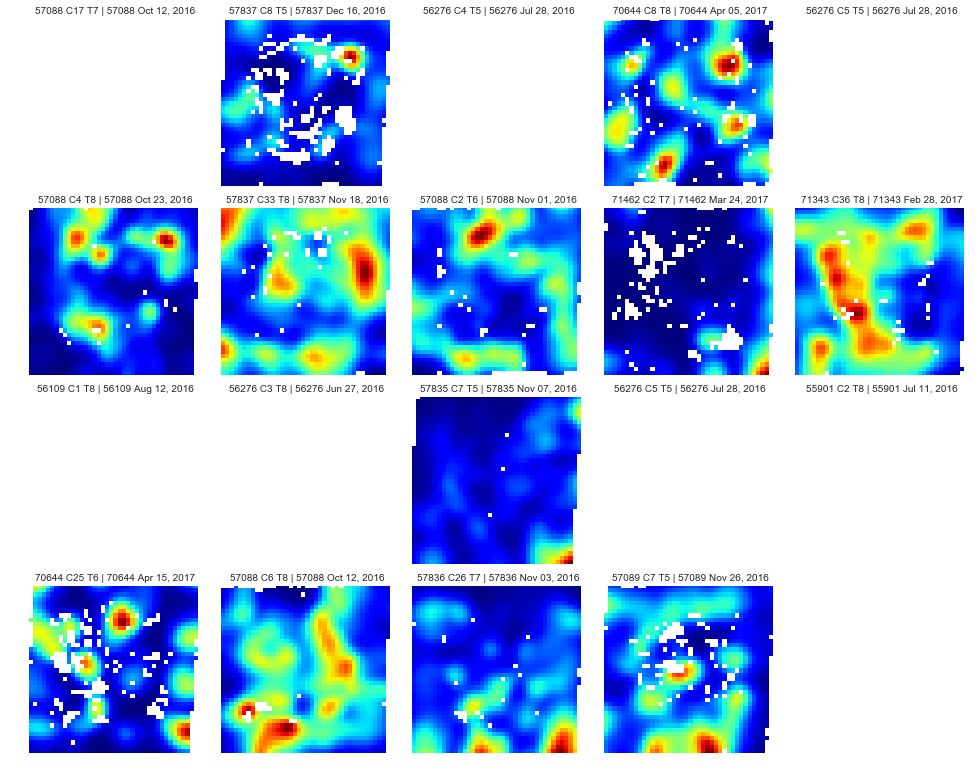

In [215]:
draw_ratemaps(base_dataframe,'masked_ratemap',19,50)


Generating plot ...


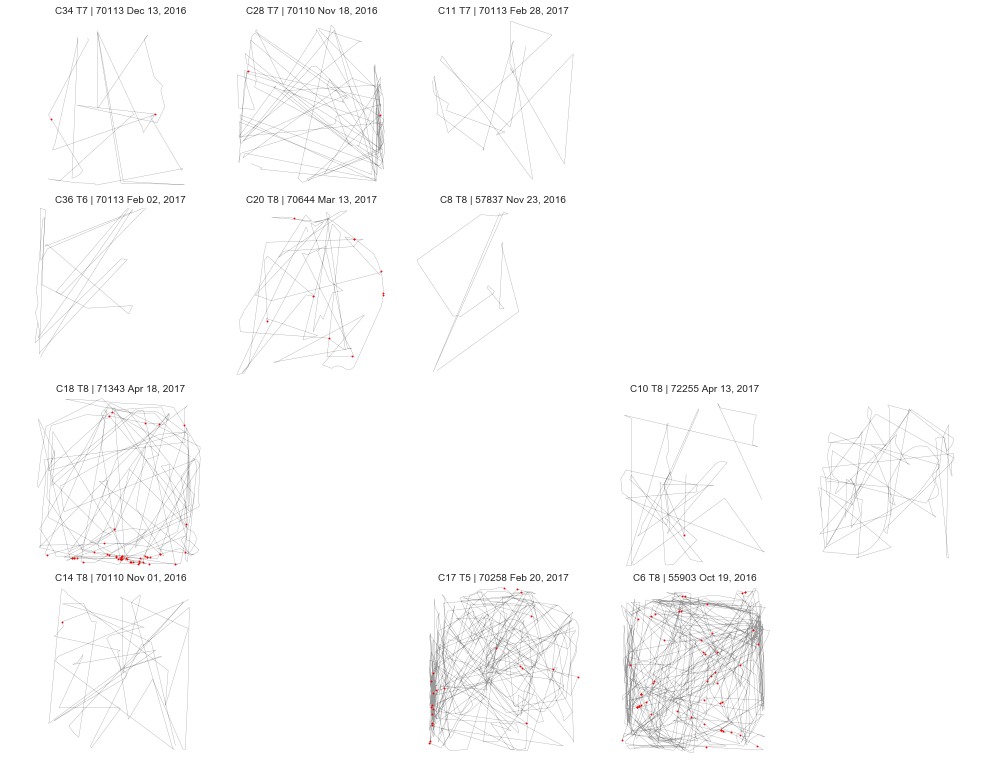

In [216]:
draw_path_spike_plots(base_dataframe,base_dataframe,19,50)


Generating plot ...


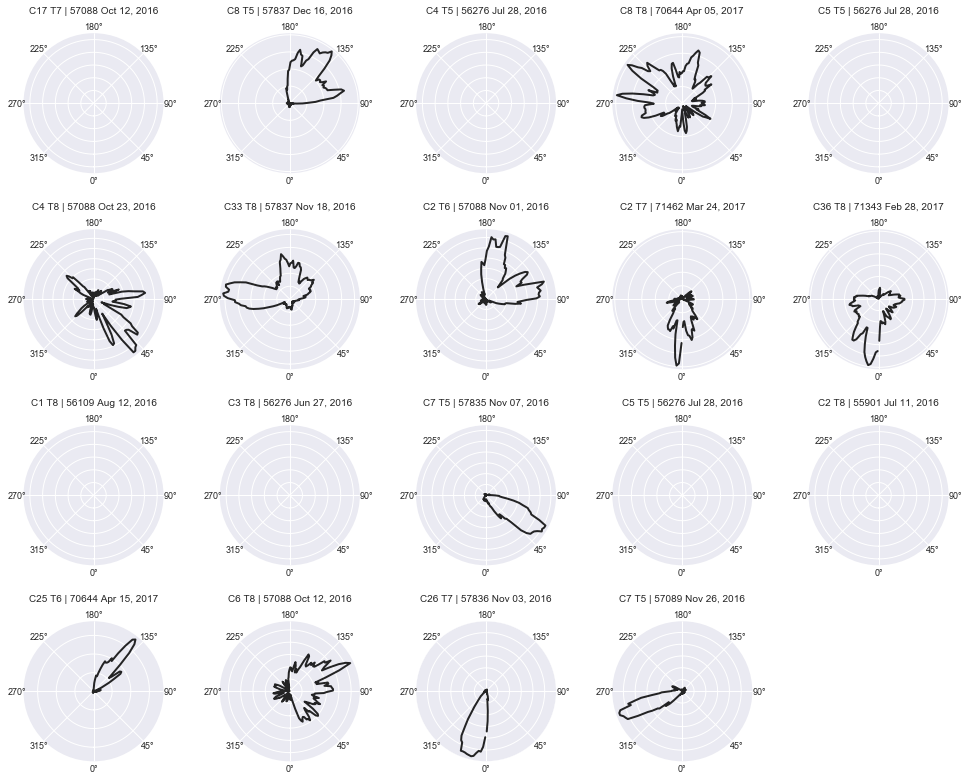

In [217]:
draw_hd_tuning_curves(base_dataframe,19,50)

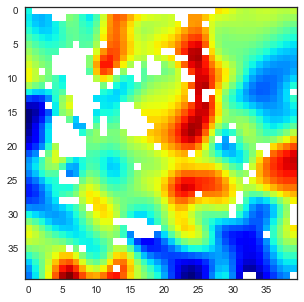

In [10]:
figure= plt.figure(figsize=(5,5))
sns.set_style('white')
plt.imshow(base_dataframe.masked_ratemap[0],interpolation='nearest',cmap='jet')

In [ ]:
base_dataframe.columns

In [ ]:
inhib_p_thresh = 0.001

In [ ]:
base_dataframe = base_dataframe.dropna(subset=['tetrode_no','cluster_no'])

In [ ]:
# sort dataframe!
base_dataframe.sort_values('inhib_lowest_p',ascending=True, inplace=True)

In [ ]:
# drop duplicates (maintaining the most significant / highest inhibited session)
base_dataframe.drop_duplicates(subset=['session_ts','animal_id','tetrode_no','cluster_no'],inplace=True)

In [ ]:
# reset indices
base_dataframe.reset_index(drop=True,inplace=True)

In [ ]:
# refresh "inhibited" label column based on inhib_p_thresh (see above)
base_dataframe['inhibited'] = (base_dataframe.inhib_lowest_p < inhib_p_thresh) & (base_dataframe.inhibited == True)

In [ ]:
len(base_dataframe)

In [ ]:
psql = psql_neuroballs(base_dataframe)

In [ ]:
psql.retrieve_data()

In [ ]:
base_dataframe = psql.data()

In [ ]:
len(base_dataframe)

### Now you have a filtered base dataset with one session per cluster

Use this to retrieve the base session data

In [ ]:
# drop session_name column
base_dataframe = base_dataframe.loc[:,~base_dataframe.columns.duplicated()]
base_dataframe.drop('session_name', 1,inplace=True)

In [ ]:
len(base_dataframe)

In [ ]:
#create_spike_plots_stimulus(base_dataframe,25,[5,5])

In [ ]:
basesessions_ = psql_neuroballs(base_dataframe)

In [ ]:
basesessions_.retrieve_data()

In [ ]:
# get the new dataframe:
basesessions_df = basesessions_.data()

In [ ]:
len(basesessions_df)

In [ ]:
draw_ratemaps(basesessions_df,'masked_ratemap',25,0)

In [ ]:
draw_hd_tuning_curves(basesessions_df,25,0)

### Save dataset for later retrieval

In [ ]:
export_path_pickle  = r"C:\work\python\klusta_analysis\postgres_notebooks\export_dataframes"
export_path_pickle = "/".join(export_path_pickle.split("\\"))
#basesessions_df.to_pickle(export_path_pickle + "/dave_arch.pkl")

#### and retrieve 

In [ ]:
basesessions_df = pd.read_pickle(export_path_pickle + "/dave_arch.pkl")

In [ ]:
len(basesessions_df)

In [ ]:
basesessions_ = psql_neuroballs(basesessions_df)

In [ ]:
basesessions_.retrieve_data()

In [ ]:
basesessions_df = basesessions_.data()

In [ ]:
basesessions_df.to_pickle(export_path_pickle + "/dave_arch.pkl")